# Modelos Machine Learning Bullying a partir de Encuesta Mundial de Salud Escolar

### Grupo 9
Integrantes:
- Cruz, Ruth
- Gabis Leccesi, Luciana
- Palma, Malena Agustina
- Stachoni, Yanina

**Dataset seleccionado:**
- Resultados encuesta EMSE
- Origen de datos: https://datos.gob.ar/ar/dataset/salud-base-datos-3deg-encuesta-mundial-salud-escolar-emse-con-resultados-nacionales-argentina


**Introducción:**

La Encuesta Mundial de Salud Escolar (EMSE) utiliza una metodología estandarizada a nivel mundial para relevar datos sobre aspectos sociodemográficos e indaga sobre conductas relacionadas con el comportamiento alimentario, el consumo de alcohol y otras drogas, la violencia y daños no intencionados, la seguridad vial, la salud mental, el consumo de tabaco, la actividad física, los comportamientos sexuales y los factores de protección.


**Objetivo:**
- Segmentar a los estudiantes en grupos basados en características similares, como hábitos alimenticios, actividad física, consumo de sustancias, y salud mental. Esto permitiría a los responsables de políticas diseñar intervenciones más específicas y dirigidas a cada grupo identificado.

In [ ]:
#Librerias necesarias
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Tratamiento de nulos y variables categóricas
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

#Escalado de variables
from sklearn.preprocessing import StandardScaler

#Algoritmos no supervisados
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

## Análisis de datos

In [ ]:
## Enlaces de google drive correspondientes al dataset y archivo de configuración
url_EMSE_completo= "https://docs.google.com/spreadsheets/d/1FdiRKlv-fCRqXQPveYltvroQenNciBPs0SJfCiYBDdM/gviz/tq?tqx=out:csv&sheet=EMSE_DatosAbiertos"
url_diccionario_dataset = "https://docs.google.com/spreadsheets/d/1CFpI6IWEcJcsPkfJYY6FrIBDuphCyB8i/gviz/tq?tqx=out:csv&sheet=Diccionario"

## Para cargar los archivos local descomentar las siguientes lineas
#url_EMSE_completo = "EMSE_DatosAbiertos.csv"
#url_diccionario_dataset = "Analisis Preguntas.xlsx"

Para este objetivo consideramos que todas las columnas pueden ser de interés por lo que trabajaremos con el dataset completo.

In [ ]:
#Leer Excel creado con la configuración de columnas
df_conf = pd.read_csv(url_diccionario_dataset)
#Si es local, usar la siguiente linea
# df_conf = pd.read_excel(url_diccionario_dataset)
#Obtener nombres de columnas del dataset
columnas_nombres = df_conf["Nombre Columna"].values

In [ ]:
#Leer el csv con los datos ya procesados en la entrega anterior
df = pd.read_csv(url_EMSE_completo)
df.columns = columnas_nombres
#Mostrar algunos datos
df.sample(3)

,edad,sexo,grado,altura,peso,hambre,comida_rapida,recibir_ataque_fisico,participar_pelea,cantidad_lesiones,...,no_venta_alcohol,amigos_alcohol,publicidad_alcohol,veces_extasis,veces_embarazo,sentir_ridiculo,padres_expectativas_altas,bajo_peso,sobre_peso,obeso
32111,15 años,Femenino,1er año/10mo grado nivel Polimodal o 3er año n...,1.62,51.0,Nunca,1 día,Ninguna,Ninguna,Ninguna,...,No intenté comprar alcohol en los últimos 30 días,Probablemente sí,Rara vez,0 veces,0 veces,Nunca,Siempre,No,No,No
41271,13 años,Masculino,9no grado nivel Primario/Polimodal o 2do año n...,NaN,NaN,Nunca,0 días,Ninguna,Ninguna,Ninguna,...,No intenté comprar alcohol en los últimos 30 días,Definitivamente no,Nunca,0 veces,0 veces,Nunca,Siempre,Dato perdido,Dato perdido,Dato perdido
37323,14 años,Femenino,1er año/10mo grado nivel Polimodal o 3er año n...,NaN,NaN,Algunas veces,0 días,Ninguna,1 vez,Dato perdido,...,No intenté comprar alcohol en los últimos 30 días,Probablemente no,Todos los días,0 veces,0 veces,Casi siempre,Nunca,Dato perdido,Dato perdido,Dato perdido


### Tratamiento de nulos y ouliers

Como ya conocemos algunas características de este dataset, procederemos a tratar nulos, outliers y variables categóricas sin mucho más análisis.

In [ ]:
#Remplazar "Dato perdido" por nan
df.replace("Dato perdido", np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56981 entries, 0 to 56980
Data columns (total 75 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad                          56873 non-null  object 
 1   sexo                          56445 non-null  object 
 2   grado                         55920 non-null  object 
 3   altura                        36052 non-null  float64
 4   peso                          36052 non-null  float64
 5   hambre                        56482 non-null  object 
 6   comida_rapida                 56771 non-null  object 
 7   recibir_ataque_fisico         56741 non-null  object 
 8   participar_pelea              56713 non-null  object 
 9   cantidad_lesiones             51559 non-null  object 
 10  tipo_lesion                   52782 non-null  object 
 11  causa_lesion                  51790 non-null  object 
 12  sentir_soledad                56615 non-null  object 
 13  s

In [ ]:
#Eliminar outliers peso
q1, q3 = df["peso"].quantile([.25, .75])
ric = q3 - q1 #rango inter quartil
l_inf = q1 - 1.5 * ric
l_sup = q3 + 1.5 * ric
df = df[df["peso"].between(l_inf, l_sup)].copy()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34878 entries, 2 to 56980
Data columns (total 75 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad                          34878 non-null  object 
 1   sexo                          34878 non-null  object 
 2   grado                         34355 non-null  object 
 3   altura                        34878 non-null  float64
 4   peso                          34878 non-null  float64
 5   hambre                        34674 non-null  object 
 6   comida_rapida                 34799 non-null  object 
 7   recibir_ataque_fisico         34776 non-null  object 
 8   participar_pelea              34763 non-null  object 
 9   cantidad_lesiones             31633 non-null  object 
 10  tipo_lesion                   32356 non-null  object 
 11  causa_lesion                  31726 non-null  object 
 12  sentir_soledad                34703 non-null  object 
 13  sentir

Notamos que al eliminar los outliers de peso, las columnas `"edad", "altura", "peso", "bajo_peso", "sobre_peso" y "obeso"` ya no tienen datos nulos por lo que no es necesario un tratamiento sobre ellos.

In [ ]:
#Convertir edad a numérico
df.edad.replace(r'[a-zñá ]', '', regex=True, inplace=True)
df.edad = pd.to_numeric(df.edad)


In [ ]:
df.shape

(34878, 75)

In [ ]:
#Analisis nulos
df_info_nulos = pd.DataFrame()
df_info_nulos['Cantidad'] = df.isnull().sum()
df_info_nulos['Porcentaje'] = (df.isnull().mean() * 100).round(2)
df_info_nulos['Tipo de dato'] = df[df_info_nulos.index].dtypes
df_info_nulos[df_info_nulos["Porcentaje"] > 0].sort_values(by="Porcentaje", ascending=False)

,Cantidad,Porcentaje,Tipo de dato
cantidad_lesiones,3245,9.30,object
causa_lesion,3152,9.04,object
tipo_lesion,2522,7.23,object
tipo_bebida_alcohol,2452,7.03,object
compartir_alcohol,2260,6.48,object
...,...,...,...
veces_fruta,157,0.45,object
veces_snakcs,142,0.41,object
participar_pelea,115,0.33,object
recibir_ataque_fisico,102,0.29,object


In [ ]:
# Verifica el tipo de datos de las columnas con valores nulos
df_info_nulos[df_info_nulos["Porcentaje"] > 0]["Tipo de dato"].unique()

array([dtype('O')], dtype=object)

Todos los nulos son de tipo texto, asi que procedemos con las transformaciones que ya habíamos analizado, utilizando la moda, es decir el "más frecuente".


In [ ]:
imputer_frequent = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
for columna in df_info_nulos[df_info_nulos["Porcentaje"] > 0].index:
    datos_imputados = imputer_frequent.fit_transform(df[[columna]])
    df[columna] =  datos_imputados[:,0]

In [ ]:
#Verificar los nulos en toda el dataset
df.isnull().sum().sum()

0

### Tratamiento variables categóricas

Convertiremos ahora las variables categóricas en numéricas, siguiendo el análisis realizado anteriormente

In [ ]:
#Buscar las columnas que tengan sólo los valores "Si" y "No"
columnas_booleanas = df.columns[df.isin(["No", "Si"]).all()].tolist()
columnas_booleanas

['pensar_suicidio',
 'plan_suicidio',
 'relaciones_sexuales',
 'intimidacion_escuela',
 'intimidacion_fuera',
 'intimidacion_internet',
 'bajo_peso',
 'sobre_peso',
 'obeso']

In [ ]:
#Reemplazar los valores por su correspondiente numérico
df[columnas_booleanas] = df[columnas_booleanas].replace({"No":0, "Si":1})
print(df[columnas_booleanas].dtypes)
np.unique(df[columnas_booleanas].values)

pensar_suicidio          int64
plan_suicidio            int64
relaciones_sexuales      int64
intimidacion_escuela     int64
intimidacion_fuera       int64
intimidacion_internet    int64
bajo_peso                int64
sobre_peso               int64
obeso                    int64
dtype: object


array([0, 1])

In [ ]:
### Columnas con una secuencia de veces
columnas_caso_1 = df.columns[df.isin(['Nunca','Algunas veces','Rara vez','Siempre','Casi siempre']).all()].tolist()
columnas_caso_1

['hambre',
 'sentir_soledad',
 'sentir_preocupacion',
 'otros_amables',
 'padres_tarea',
 'padres_atencion',
 'padres_tiempo_libre',
 'padres_revisar',
 'sentir_ridiculo',
 'padres_expectativas_altas']

In [ ]:
valores = {
    'Nunca': 0
    ,'Rara vez': 1
    ,'Algunas veces': 2
    ,'Casi siempre': 3
    ,'Siempre': 4
}
df[columnas_caso_1] = df[columnas_caso_1].replace(valores)


In [ ]:
### Columnas cuyos valores indican cantidad y pueden convertirse a número extrayendo el valor del texto
# Seleccionar las columnas que su nombre comience con "dias", "edad" o "cantidad"
columnas_cantidad = [col for col in df.columns if col.startswith(("dias_","edad_", "cantidad_", "veces_"))]
# Agregar otras columnas que también tienen valores que pueden convertirse a numéricos
columnas_cantidad.extend(["participar_pelea", "intentar_suicidio", "amigos_cercanos","problemas_alcohol",
                          "comida_rapida", "recibir_ataque_fisico", "otro_tabaco", "otros_fumar",
                          "conductor_alcohol", "personas_relaciones_sexuales", "tiempo_sentado"])
# Ver todos los valores
np.unique(df[columnas_cantidad].values)

array(['0', '0 días', '0 veces', '1', '1 a 2 horas al día',
       '1 a 3 veces durante los últimos 7 días', '1 día', '1 o 2 días',
       '1 o 2 veces', '1 persona', '1 trago', '1 vez', '1 vez al día',
       '10 a 19 días', '10 a 19 veces', '10 días o más', '10 o 11 años',
       '10 o más veces', '10 u 11 años', '10 u 11 veces',
       '11 años o menos', '12 años', '12 o 13 años', '12 o más veces',
       '13 años', '14 años', '14 o 15 años', '15 años', '16 o 17 años',
       '18 años o más', '2', '2 días', '2 o 3 veces', '2 o más veces',
       '2 personas', '2 tragos', '2 veces al día', '20 a 29 días',
       '20 veces o más', '3 a 4 horas al día', '3 a 5 días',
       '3 a 9 veces', '3 días', '3 o 4 días', '3 o más', '3 personas',
       '3 tragos', '3 veces al día',
       '4 a 6 veces durante los últimos 7 días', '4 días', '4 o 5 veces',
       '4 o más veces al día', '4 personas', '4 tragos',
       '5 a 6 horas al día', '5 días', '5 días o más', '5 o 6 días',
       '5 person

In [ ]:
# Reemplazar todos los valores que tengan "Nunca" por 0.
df[columnas_cantidad] = df[columnas_cantidad].replace(r'(^Nunca.*$)', 0, regex=True) #  Expresión regular "empieza por Nunca"
# Reemplazar todos los valores que tengan "No" por 0.
df[columnas_cantidad] = df[columnas_cantidad].replace(r'(^No.*$)', 0, regex=True) #  Expresión regular "empieza por No"
# Reemplazar todos los valores que tengan "Menos" por 0.
df[columnas_cantidad] = df[columnas_cantidad].replace(r'(^Menos.*$)', 0, regex=True) #  Expresión regular "empieza por Menos"
# Reemplazar "Ninguna" por 0, "Los 30 días" por 30, "Los 7 días" por 7
df[columnas_cantidad] = df[columnas_cantidad].replace({"Ninguna": 0, "Los 30 días": 30, "Los 7 días": 7, "Más de 8 horas por día": 8})
# Reemplazar los valores restantes por el primer texto antes del espacio
for col in columnas_cantidad:
    df[col] = df[col].astype(str).apply(lambda x: x.split()[0])
# Verificar los nuevos valores
np.unique(df[columnas_cantidad].values)

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '18', '2',
       '20', '3', '30', '4', '5', '6', '7', '8'], dtype=object)

In [ ]:
#Convertir esas columnas a número entero
df[columnas_cantidad] = df[columnas_cantidad].astype(int)
df.dtypes

,0
edad,int64
sexo,object
grado,object
altura,float64
peso,float64
...,...
sentir_ridiculo,int64
padres_expectativas_altas,int64
bajo_peso,int64
sobre_peso,int64


In [ ]:
df.select_dtypes("object").columns

Index(['sexo', 'grado', 'tipo_lesion', 'causa_lesion', 'dejar_cigarrillo',
       'padres_fuman', 'conseguir_alcohol', 'preservativo',
       'otro_anticonceptivo', 'padre_educacion', 'madre_educacion',
       'uso_cinturon', 'casco_bicicleta', 'casco_moto', 'tipo_bebida_alcohol',
       'compartir_alcohol', 'no_venta_alcohol', 'amigos_alcohol',
       'publicidad_alcohol'],
      dtype='object')

In [ ]:
#Valores en las columnas categoricas que quedan
for col in df.select_dtypes("object").columns:
    print(f'{col}: {df[col].unique()}')

sexo: ['Masculino' 'Femenino']
grado: ['2do año/11vo grado nivel Polimodal o 4to año nivel Secundario'
 '9no grado nivel Primario/Polimodal o 2do año nivel Secundario'
 '1er año/10mo grado nivel Polimodal o 3er año nivel Secundario'
 '3er año/12vo grado nivel Polimodal o 5to año nivel Secundario'
 '8vo grado nivel Primario/Polimodal  o 1er año nivel Secundario']
tipo_lesion: ['Tuve un hueso roto o una articulación dislocada'
 'No tuve ninguna lesión seria o grave en los últimos 12 meses'
 'Me sucedió otra cosa'
 'Sufrí un golpe u otra lesión en la cabeza o el cuello, me desmayé o no podía respirar'
 'Recibí un corte, una punzada o puñalada' 'Sufrí una quemadura grave'
 'Recibí una herida con arma de fuego'
 'Perdí todo o parte de un pie, pierna, mano o brazo']
causa_lesion: ['Otra cosa causó mi lesión'
 'No sufrí ninguna lesión seria o grave durante los últimos 12 meses'
 'Me caí' 'Algo me cayó encima o me golpeó'
 'Fui atacado, agredido, abusado o estaba peleando con alguien'
 'Tuve u

In [ ]:
encoder = LabelEncoder()
for col in df.select_dtypes("object").columns:
    df[col] = encoder.fit_transform(df[col])
    for i, l in enumerate(encoder.classes_):
      print(f'Valores en columna {col}: {l}= {i}')

Valores en columna sexo: Femenino= 0
Valores en columna sexo: Masculino= 1
Valores en columna grado: 1er año/10mo grado nivel Polimodal o 3er año nivel Secundario= 0
Valores en columna grado: 2do año/11vo grado nivel Polimodal o 4to año nivel Secundario= 1
Valores en columna grado: 3er año/12vo grado nivel Polimodal o 5to año nivel Secundario= 2
Valores en columna grado: 8vo grado nivel Primario/Polimodal  o 1er año nivel Secundario= 3
Valores en columna grado: 9no grado nivel Primario/Polimodal o 2do año nivel Secundario= 4
Valores en columna tipo_lesion: Me sucedió otra cosa= 0
Valores en columna tipo_lesion: No tuve ninguna lesión seria o grave en los últimos 12 meses= 1
Valores en columna tipo_lesion: Perdí todo o parte de un pie, pierna, mano o brazo= 2
Valores en columna tipo_lesion: Recibí un corte, una punzada o puñalada= 3
Valores en columna tipo_lesion: Recibí una herida con arma de fuego= 4
Valores en columna tipo_lesion: Sufrí un golpe u otra lesión en la cabeza o el cuello

In [ ]:
#Verificar que todas las columnas sean numéricas y no contengan nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34878 entries, 2 to 56980
Data columns (total 75 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad                          34878 non-null  int64  
 1   sexo                          34878 non-null  int64  
 2   grado                         34878 non-null  int64  
 3   altura                        34878 non-null  float64
 4   peso                          34878 non-null  float64
 5   hambre                        34878 non-null  int64  
 6   comida_rapida                 34878 non-null  int64  
 7   recibir_ataque_fisico         34878 non-null  int64  
 8   participar_pelea              34878 non-null  int64  
 9   cantidad_lesiones             34878 non-null  int64  
 10  tipo_lesion                   34878 non-null  int64  
 11  causa_lesion                  34878 non-null  int64  
 12  sentir_soledad                34878 non-null  int64  
 13  sentir

## Reducción de dimensionalidad

In [ ]:
# Escalado de los datos
scaling=StandardScaler()

scaling.fit(df)
X_scaled=pd.DataFrame(scaling.transform(df), columns = df.columns)

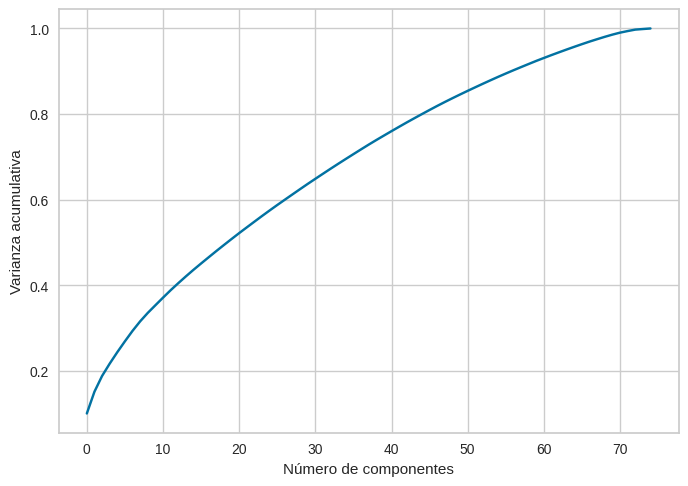

In [ ]:
# Varianza acumulativa para estimar cantidad de componentes principales
pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulativa')
plt.show();

Como la curva es suave, fijamos un límite para tener al menos el 70% de los datos explicados.

In [ ]:
# Retener el 70 % de la varianza
pca = PCA(n_components=0.7).fit(X_scaled)

print("Número de componentes: ",pca.n_components_)

Número de componentes:  36


In [ ]:
# Aplicar PCA con 36 componentes principales
pca = PCA(n_components=36, random_state = 42)

pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

In [ ]:
print("Forma original: {}".format(str(df.shape)))
print("Forma reducida: {}".format(str(X_pca.shape)))

Forma original: (34878, 75)
Forma reducida: (34878, 36)


## Análisis no supervisado

### Algoritmo K-Means

Graficaremos con el método de silhouette para encontrar un número de grupos (clústers o K) adecuado

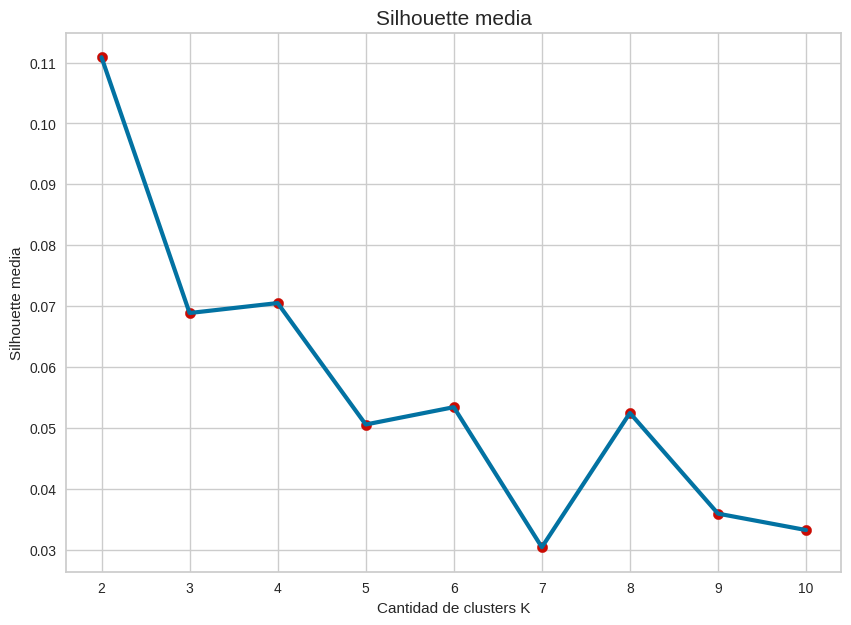

In [ ]:
K = np.arange(2,11)
lista_sil = []

# Entrenamos un modelo para cada número de cluster que queremos testear
for k in range(2,11):
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k, n_init='auto')
    km = km.fit(X_pca)

    # Tomamos las etiquetas
    etiquetas = km.labels_

    # Calculamos el silhouette
    valor_medio_sil = silhouette_score(X_pca, etiquetas)
    lista_sil.append(valor_medio_sil)

plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media', fontsize = 15)

plt.show()

Parece que un K = 2 tiene una buena métrica silohuette.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state = 42, n_init='auto')

Kmeans_clusters = kmeans.fit_predict(X_pca)

X_scaled['Clusters'] = Kmeans_clusters

# Se agregaran los cluster al dataset original
df['Clusters'] = Kmeans_clusters

In [ ]:
total_var = pca.explained_variance_ratio_.sum() * 100
print(f'Varianza total explicada: {total_var:.2f}%',)

Varianza total explicada: 70.35%


#### Análisis de clústers

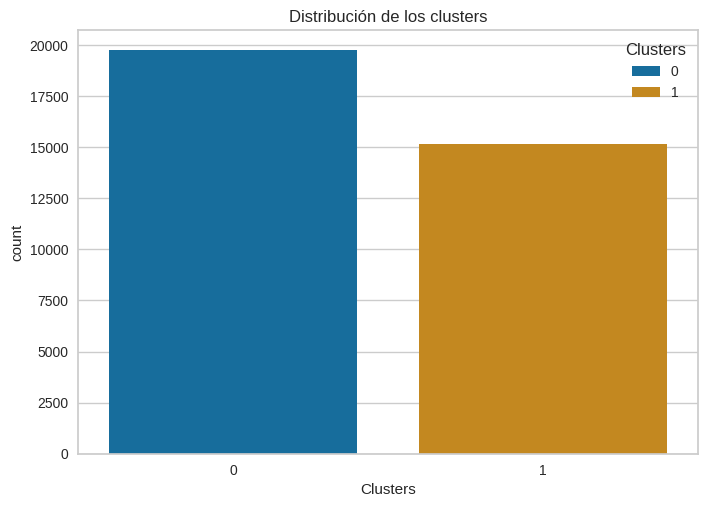

In [ ]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["Clusters"], hue=df["Clusters"], palette="colorblind")
pl.set_title("Distribución de los clusters")
plt.show()

Los clústers se ven distribuídos bastante parejos. Hay una diferencia aproximada de 5000 alumnos.

In [ ]:
clusters_edad = df.groupby(["edad","Clusters"])["Clusters"].size().reset_index(name='cantidad')
total_edad = df['edad'].value_counts().reset_index()
total_edad.columns = ['edad', 'total']
clusters_edad = pd.merge(clusters_edad, total_edad, on='edad')

# Calcular el porcentaje
clusters_edad['porcentaje_edad'] = (clusters_edad['cantidad'] / clusters_edad['total']) * 100
clusters_edad

,edad,Clusters,cantidad,total,porcentaje_edad
0,11,0,13,16,81.250000
1,11,1,3,16,18.750000
2,12,0,58,66,87.878788
3,12,1,8,66,12.121212
4,13,0,4850,5648,85.871105
5,13,1,798,5648,14.128895
6,14,0,5306,7463,71.097414
7,14,1,2157,7463,28.902586
8,15,0,4327,7843,55.170215
9,15,1,3516,7843,44.829785


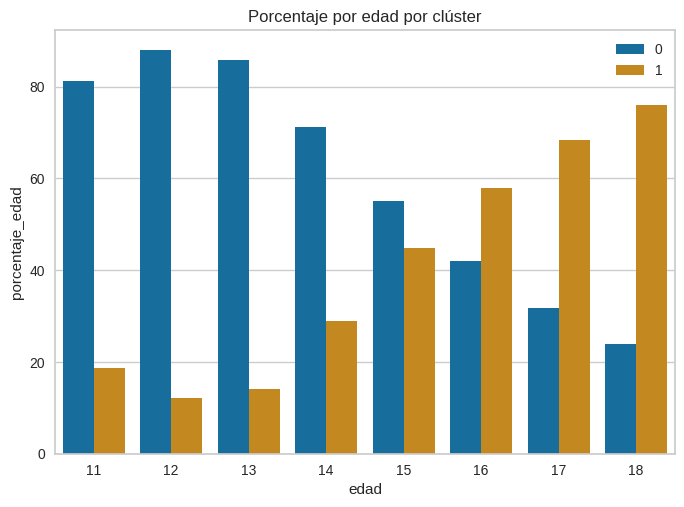

In [ ]:
pl = sns.barplot(data = clusters_edad,x="edad", y="porcentaje_edad",hue="Clusters", palette= "colorblind")
pl.set_title("Porcentaje por edad por clúster")
plt.legend()
plt.show()

Podemos ver que el Clúster 0 es el que más representación tiene entre los alumnos de 11 a 15 años.

En contraparte, el Clúster 1 es el que más representa a individuos de 16 a 18 años.


In [ ]:
clusters_sexo = df.groupby(["sexo","Clusters"])["Clusters"].size().reset_index(name='cantidad')
total_sexo = df['sexo'].value_counts().reset_index()
total_sexo.columns = ['sexo', 'total']
clusters_sexo = pd.merge(clusters_sexo, total_sexo, on='sexo')

# Calcular el porcentaje
clusters_sexo['porcentaje_sexo'] = (clusters_sexo['cantidad'] / clusters_sexo['total']) * 100
clusters_sexo

,sexo,Clusters,cantidad,total,porcentaje_sexo
0,0,0,10699,18772,56.994460
1,0,1,8073,18772,43.005540
2,1,0,9042,16106,56.140569
3,1,1,7064,16106,43.859431


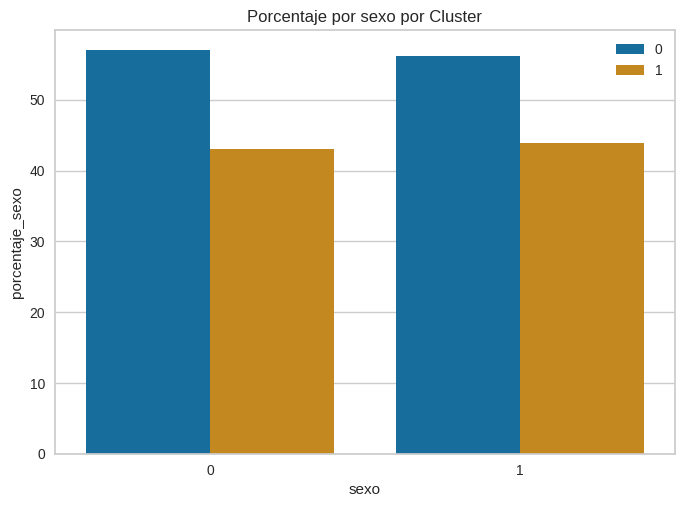

In [ ]:
pl = sns.barplot(data = clusters_sexo,x="sexo", y="porcentaje_sexo",hue="Clusters", palette= "colorblind")
pl.set_title("Porcentaje por sexo por Cluster")
plt.legend()
plt.show()

No distingue por genero.

##### Análisis por componentes principales

Analizamos que variables intervienen en cada componente principal.

In [ ]:
columns = [f'Componente principal {i+1}' for i in range (0,36)]


pdf=pd.DataFrame(data=X_pca,columns=columns)
pdf.head()



,Componente principal 1,Componente principal 2,Componente principal 3,Componente principal 4,Componente principal 5,Componente principal 6,Componente principal 7,Componente principal 8,Componente principal 9,Componente principal 10,...,Componente principal 27,Componente principal 28,Componente principal 29,Componente principal 30,Componente principal 31,Componente principal 32,Componente principal 33,Componente principal 34,Componente principal 35,Componente principal 36
0,-3.496618,-1.699726,1.424846,-0.419981,0.918823,0.011000,1.386353,0.422469,2.213230,-1.155432,...,0.457896,0.663161,0.853219,1.381835,-0.111351,0.376612,-1.148805,-0.252645,-0.020138,0.450932
1,0.116092,-2.955313,-0.430411,-0.346725,0.870337,-0.526580,0.286745,-0.756128,-0.170217,0.342824,...,-0.905538,0.651318,1.059919,0.531656,1.357743,2.379412,0.821912,-0.341509,-0.399593,0.648494
2,-2.361420,-1.821106,0.244831,1.509264,2.958218,0.806163,0.872154,-0.927936,1.407105,0.817181,...,-0.285262,-0.226332,0.884605,0.677316,-0.649722,0.045681,-0.688596,-0.205878,0.340256,-0.033429
3,1.273148,-1.444581,-1.075349,1.669482,2.735521,-1.196043,-0.356092,-0.921675,-1.071939,1.596590,...,0.006495,-2.710043,0.319114,0.968649,-0.473816,-0.941134,-0.712316,1.488305,-1.097181,-0.428634
4,-3.396327,1.310612,0.876481,1.819924,-0.731595,-1.638395,-1.511456,0.645415,-0.210119,0.167775,...,0.540330,-0.254846,-0.780847,0.494483,0.314776,-0.060567,0.292338,0.377622,0.227982,-0.052235


In [ ]:
columns = [column for column in df.columns if column not in ['Clusters']]
df_pca = pd.DataFrame(pca.components_, columns=columns)
df_pca = df_pca.T

df_pca[0].sort_values(key=abs, ascending=False).head(15)


,0
conseguir_alcohol,-0.239411
dias_mucho_alcohol,0.235805
personas_relaciones_sexuales,0.224982
edad_relaciones_sexuales,0.221169
edad_cigarrillo,0.217373
relaciones_sexuales,0.215369
edad_drogas,0.209712
veces_borracho,0.208263
no_venta_alcohol,0.204874
tipo_bebida_alcohol,-0.198753


Podemos ver que el "Componente Principal 1" está mayormente compuesto por variables relacionadas al alcohol, relaciones sexuales y edad de inicio en cigarrillo y drogas.

In [ ]:
df_pca[1].sort_values(key=abs, ascending=False).head(15)

,1
sentir_soledad,0.287971
pensar_suicidio,0.287807
plan_suicidio,0.270273
sentir_ridiculo,0.250122
sentir_preocupacion,0.234499
intentar_suicidio,0.225906
sexo,-0.215388
altura,-0.214210
padres_atencion,-0.199252
peso,-0.183798


El componente principal 2 está relacionado a variables personales como sentimientos, suicidio, sexo, altura y peso

<ipython-input-43-90bb4c684419>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pdf.loc[indicesToKeep, 'Componente principal 1']


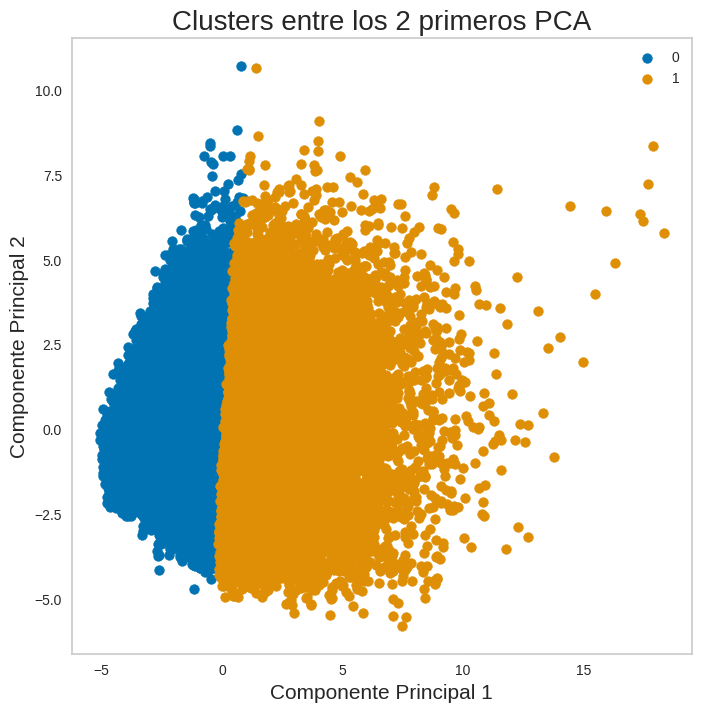

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Componente Principal 1', fontsize = 15)
ax.set_ylabel('Componente Principal 2', fontsize = 15)
ax.set_title('Clusters entre los 2 primeros PCA', fontsize = 20)
targets = [0,1]
colors = sns.color_palette('colorblind')
for target, color in zip(targets,colors):
    indicesToKeep = X_scaled['Clusters'] == target
    ax.scatter(pdf.loc[indicesToKeep, 'Componente principal 1']
               , pdf.loc[indicesToKeep, 'Componente principal 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Distribución de clústers entre los 2 primeros PCA

In [ ]:
df_princ_pca = df.groupby(['Clusters', 'conseguir_alcohol', 'sentir_soledad'], as_index=False).size()
df_princ_pca

,Clusters,conseguir_alcohol,sentir_soledad,size
0,0,0,0,84
1,0,0,1,65
2,0,0,2,48
3,0,0,3,13
4,0,0,4,3
...,...,...,...,...
63,1,6,0,293
64,1,6,1,320
65,1,6,2,444
66,1,6,3,309


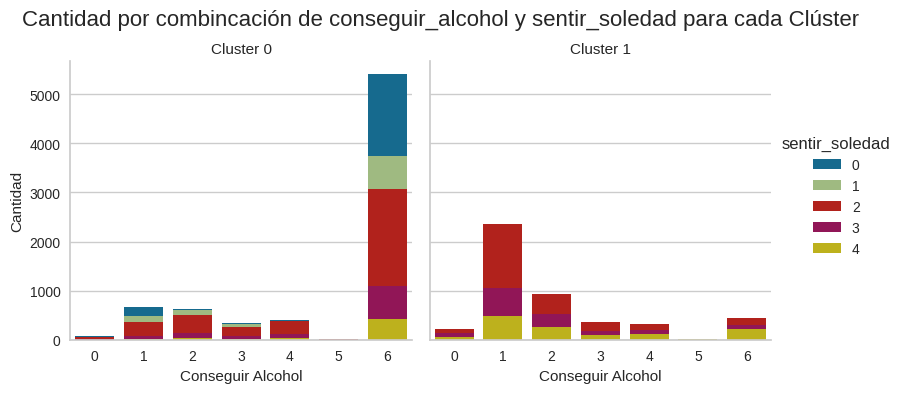

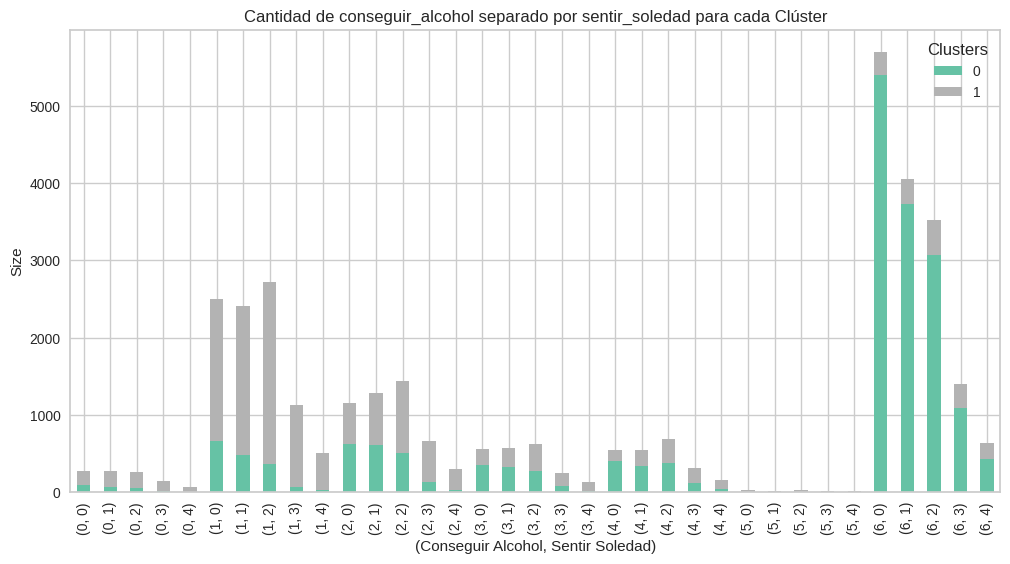

In [ ]:
#Crear gráficos que permitan comparar dos variables categóricas
# FacetGrid
g = sns.FacetGrid(df_princ_pca, col='Clusters', hue='sentir_soledad', height=4, aspect=1)
g.map(sns.barplot, 'conseguir_alcohol', 'size', order=sorted(df['conseguir_alcohol'].unique()), errorbar=None)
g.add_legend()
g.set_axis_labels('Conseguir Alcohol', 'Cantidad')
g.set_titles(col_template='Cluster {col_name}')
g.fig.suptitle('Cantidad por combincación de conseguir_alcohol y sentir_soledad para cada Clúster', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

# Barras apiladas
stacked_data = df_princ_pca.groupby(['conseguir_alcohol', 'sentir_soledad', 'Clusters'])['size'].sum().unstack().fillna(0)
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Cantidad de conseguir_alcohol separado por sentir_soledad para cada Clúster')
plt.xlabel('(Conseguir Alcohol, Sentir Soledad)')
plt.ylabel('Size')
plt.legend(title='Clusters', loc='best')
plt.show()


Vemos que el clúster 0 contiene a los individuos que No tomaron alcohol o no se sienten solos.

El clúster 1 mayormente a quienes algunas veces, siempre y casi siempre se sienten solos. Y consiguieron alcohol.

In [ ]:
df_princ_pca2 = df.groupby(['Clusters', 'dias_mucho_alcohol', 'pensar_suicidio'], as_index=False).size()
df_princ_pca2

,Clusters,dias_mucho_alcohol,pensar_suicidio,size
0,0,0,0,13157
1,0,0,1,2013
2,0,1,0,1327
3,0,1,1,157
4,0,2,0,988
5,0,2,1,134
6,0,3,0,701
7,0,3,1,85
8,0,4,0,373
9,0,4,1,40


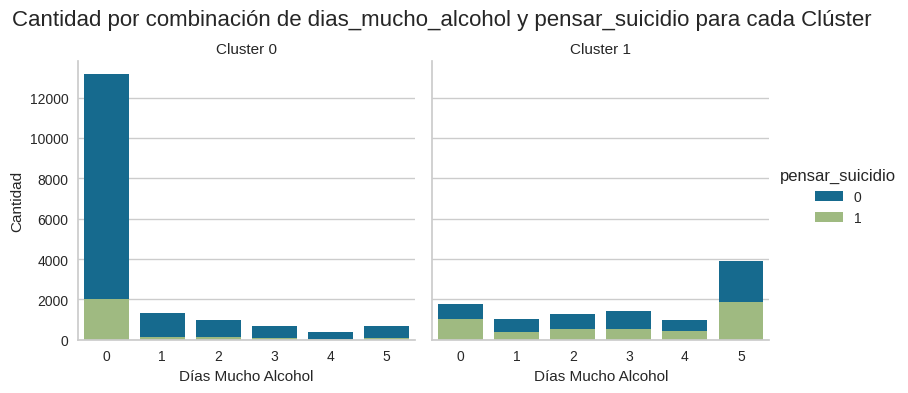

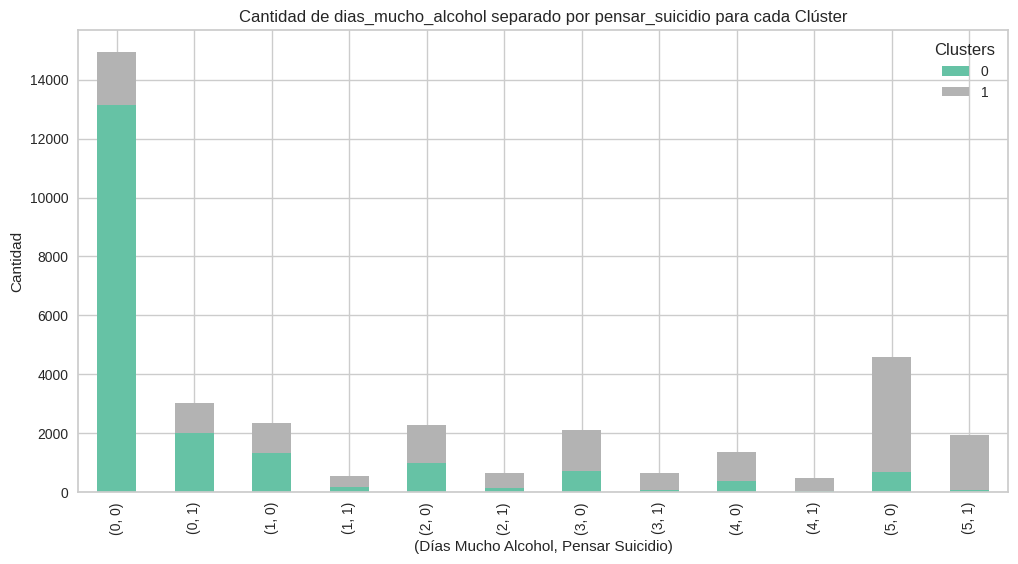

In [ ]:
#FacetGrid
g = sns.FacetGrid(df_princ_pca2, col='Clusters', hue='pensar_suicidio', height=4, aspect=1)
g.map(sns.barplot, 'dias_mucho_alcohol', 'size', order=sorted(df['dias_mucho_alcohol'].unique()), errorbar=None)
g.add_legend()
g.set_axis_labels('Días Mucho Alcohol', 'Cantidad')
g.set_titles(col_template='Cluster {col_name}')
g.fig.suptitle('Cantidad por combinación de dias_mucho_alcohol y pensar_suicidio para cada Clúster', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

# Barras apiladas
stacked_data = df_princ_pca2.groupby(['dias_mucho_alcohol', 'pensar_suicidio', 'Clusters'])['size'].sum().unstack().fillna(0)
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Cantidad de dias_mucho_alcohol separado por pensar_suicidio para cada Clúster')
plt.xlabel('(Días Mucho Alcohol, Pensar Suicidio)')
plt.ylabel('Cantidad')
plt.legend(title='Clusters', loc='best')
plt.show()


Al igual que en el caso anterior, en el clúster 0 están las personas que no tomaron más de 2 tragos de alcohol ningún día y que no pensaron el el suicidio.
En el clúster 1 personas que pensaron en cometer suicidio y tomaron alcohol.

In [ ]:
df_pca[2].sort_values(key=abs, ascending=False).head(15)

,2
veces_marihuana_mes,0.311349
edad_alcohol,-0.288931
veces_marihuana,0.275331
amigos_alcohol,-0.274535
otro_tabaco,0.261117
tipo_bebida_alcohol,0.253565
veces_anfetaminas,0.252899
compartir_alcohol,0.245363
veces_extasis,0.226788
conseguir_alcohol,0.211871


En el componente 3 se agrupan temas principalmente relacionados a drogas.

In [ ]:
df_pca[4].sort_values(key=abs, ascending=False).head(15)

,4
veces_snakcs,0.263461
edad,-0.258357
padres_tarea,0.255588
comida_rapida,0.242863
veces_gaseosa,0.239058
participar_pelea,0.190092
dias_act_fisica,0.189134
padres_expectativas_altas,0.189013
grado,0.183903
cantidad_lesiones,0.175976


En el componente 4 estan las características relacionadas a la comida y relación con los padres

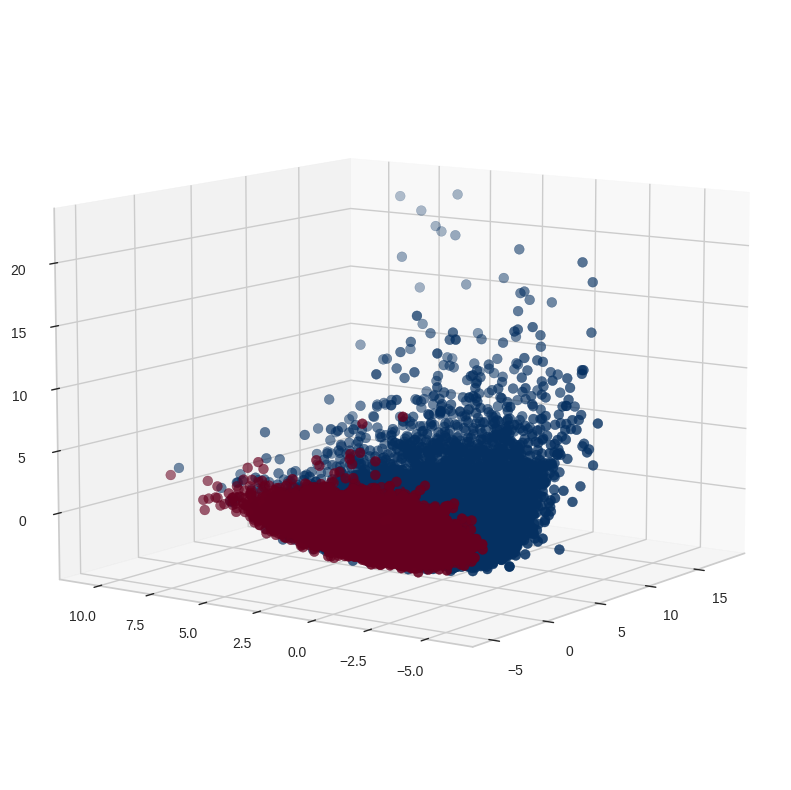

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2], s=50, c=Kmeans_clusters, cmap='RdBu')
ax.view_init(10, 215)
plt.show()

Distribución de los clústers entre los primeros 3 PCA

In [ ]:
df_otros_pca = df.groupby(['Clusters', 'veces_marihuana_mes', 'padres_tarea'], as_index=False).size()
df_otros_pca

,Clusters,veces_marihuana_mes,padres_tarea,size
0,0,0,0,5392
1,0,0,1,3576
2,0,0,2,3933
3,0,0,3,3416
4,0,0,4,3302
5,0,1,0,27
6,0,1,1,24
7,0,1,2,25
8,0,1,3,9
9,0,1,4,2


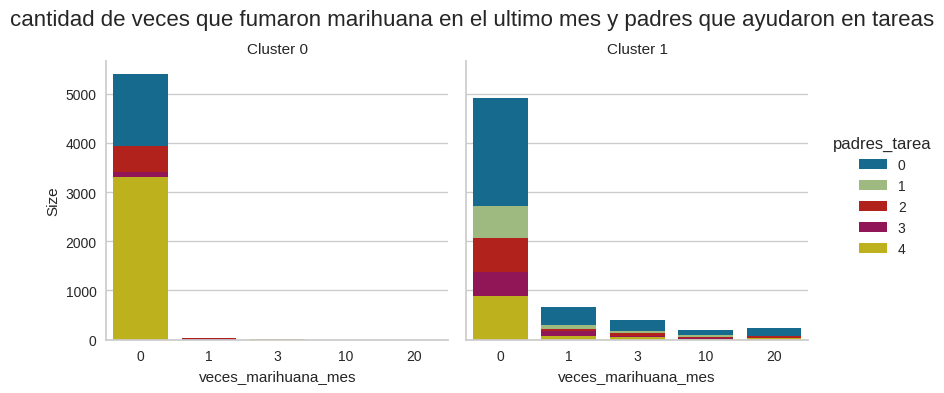

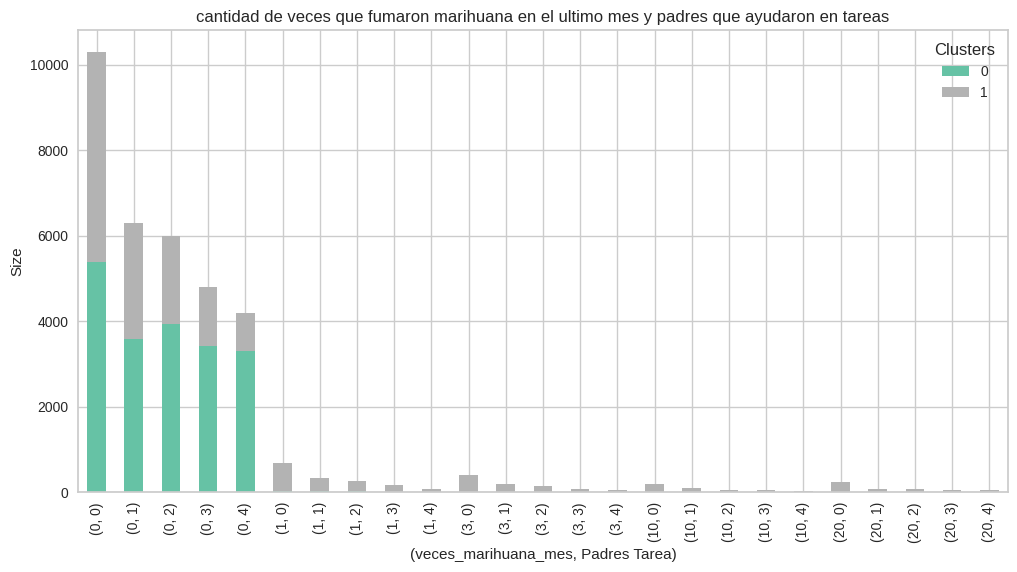

In [ ]:
# Create a FacetGrid
g = sns.FacetGrid(df_otros_pca, col='Clusters', hue='padres_tarea', height=4, aspect=1)
g.map(sns.barplot, 'veces_marihuana_mes', 'size', order=sorted(df['veces_marihuana_mes'].unique()), errorbar=None)
g.add_legend()

# Add titles and labels
g.set_axis_labels('veces_marihuana_mes', 'Size')
g.set_titles(col_template='Cluster {col_name}')
g.fig.suptitle('cantidad de veces que fumaron marihuana en el ultimo mes y padres que ayudaron en tareas', fontsize=16)

# Show the plot
plt.subplots_adjust(top=0.85)  # Adjust title position
plt.show()

# Prepare data for stacked bar plot
stacked_data = df_otros_pca.groupby(['veces_marihuana_mes', 'padres_tarea', 'Clusters'])['size'].sum().unstack().fillna(0)

# Create a stacked bar plot
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

# Add titles and labels
plt.title('cantidad de veces que fumaron marihuana en el ultimo mes y padres que ayudaron en tareas')
plt.xlabel('(veces_marihuana_mes, Padres Tarea)')
plt.ylabel('Size')
plt.legend(title='Clusters', loc='best')

# Show the plot
plt.show()

En el cluster 0 los padres los ayudan con las tareas o no los ayudan. Casi no hay termino medio. y nunca fumaron marihuana en el ultimo mes.

y el el cluster 1 las gran mayoria no conumió marihuana, pero hay mas consumidores con respecto al cluster 0. Y los padres mayormente no los ayudan con las tareas.

In [ ]:
clusters_embarazo = df.groupby(["Clusters", 'veces_embarazo'])['veces_embarazo'].agg(total='count').reset_index()
df_embarazo = df["veces_embarazo"].value_counts()

clusters_embarazo = pd.merge(clusters_embarazo, df_embarazo, on='veces_embarazo')

# Calcular el porcentaje
clusters_embarazo['porcentaje_veces'] = (clusters_embarazo['total'] / clusters_embarazo['count']) * 100
clusters_embarazo

,Clusters,veces_embarazo,total,count,porcentaje_veces
0,0,0,19516,33962,57.464225
1,1,0,14446,33962,42.535775
2,0,1,171,702,24.358974
3,1,1,531,702,75.641026
4,0,2,54,214,25.233645
5,1,2,160,214,74.766355


In [ ]:
embarazo_edad = df.groupby(["Clusters", 'veces_embarazo', 'edad'], as_index=False).size()
embarazo_edad

,Clusters,veces_embarazo,edad,size
0,0,0,11,12
1,0,0,12,58
2,0,0,13,4792
3,0,0,14,5260
4,0,0,15,4291
5,0,0,16,3299
6,0,0,17,1750
7,0,0,18,54
8,0,1,11,1
9,0,1,13,37


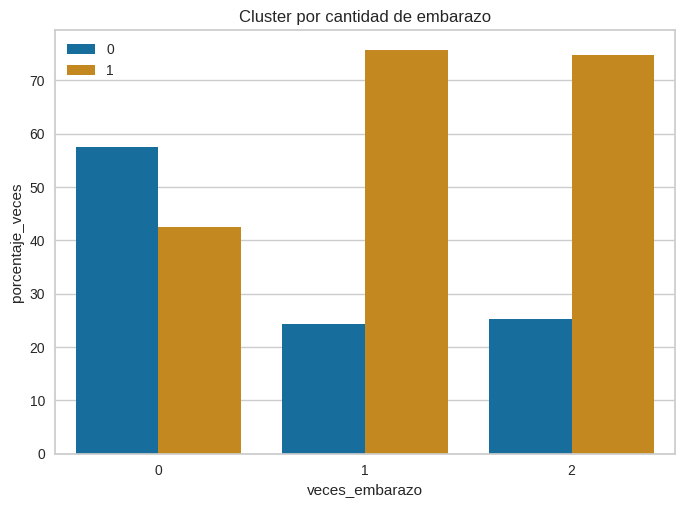

In [ ]:
pl = sns.barplot(data = clusters_embarazo,x="veces_embarazo", y="porcentaje_veces",hue="Clusters", palette= "colorblind")
pl.set_title("Cluster por cantidad de embarazo")
plt.legend()
plt.show()

Vemos que los individuos que participaron en un embarazos están mayormente en el clúster 1 y quienes estuvieron involucrados en 1 embarazos están en su mayoría en el clúster 0.

##Conclusiones

El análisis con kMeans reveló dos clústeres bien diferenciados.

El **Clúster 0** agrupa principalmente a estudiantes de 11 a 15 años que no consumen alcohol, no se sienten solos, no han pensado en el suicidio, no han fumado marihuana y reciben apoyo de sus padres con las tareas.

Por otro lado, el **Clúster 1** se compone mayoritariamente de adolescentes de 16 a 18 años que han experimentado soledad, han consumido alcohol, han considerado el suicidio y, en menor medida, han consumido marihuana, con menos apoyo parental en tareas escolares.